In [2]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random




from sklearn.model_selection import train_test_split
import timeit

# CALIBRATED PROBABILITIES

Although all classification models can give you a numeric score when you call predict_proba, not all of them give you a real probability, i.e. a value between 0 a 1 that fits the real probability distribution in the data in a frequentist sense. 

In these cases, this numeric value can be used to *rank* predictions, and therefore AUC score will not be affected, but does not allow you to get intuition or use this numeric score directly as a probability. These numeric scores are called *non-calibrated probabilities*.

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

These numeric values can be transformed into a real probability, or something close to one, by process called *calibration*. Let's see how this works.

## Dataset

Let's use an artifical dataset.

In [3]:
from sklearn.datasets import make_classification
?make_classification

In [5]:
random_state = 534
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.2,0.8], random_state= random_state)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)


## Non-calibrated Model


### XGBoost

Let's train a model that does not give calibrated probabilities, like XGBoost.

In [7]:
# 1) Import model
from xgboost import XGBClassifier as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# 3) Define model
model = model_constructor(random_state = 0)

# 4) Train model
model.fit(X_train, np.array(y_train))

# 5) Predict
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test) 

# Compute metric
AUC_test = metric(y_test, pred_test_p[:,1])
AUC_test

[13:05:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\jesus\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9428480594751901

It is important to note here that XGBoost does not return real (calibrated) probabilities but simply a numerical score that allows ordering between cases with more and less probability of cancer.

This can be seen in the following graph, called **calibration curve**.

In [8]:
from sklearn.calibration import calibration_curve
?calibration_curve

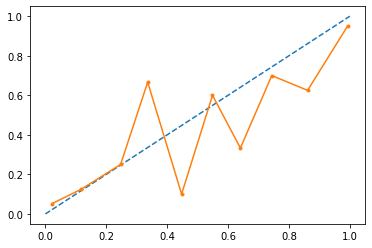

In [9]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Blue dashed line is the expected line for a calibrated probability. We can see that XGboost probabilites are not well calibrated.

Let's try other models.

### SVM

In [10]:
# 1) Import model
from sklearn.svm import SVC as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# 3) Define model
model = model_constructor(random_state = 0,
                          probability = True)

# 4) Train model
model.fit(X_train, np.array(y_train))

# 5) Predict
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test) 

# Compute metric
AUC_test = metric(y_test, pred_test_p[:,1])
AUC_test

0.9403536230466363

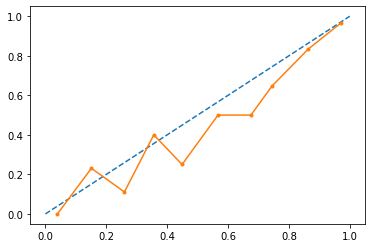

In [11]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

### Random Forest

In [12]:
# 1) Import model
from sklearn.ensemble import RandomForestClassifier as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# 3) Define model
model = model_constructor(random_state = 0)

# 4) Train model
model.fit(X_train, np.array(y_train))

# 5) Predict
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test) 

# Compute metric
AUC_test = metric(y_test, pred_test_p[:,1])
AUC_test

0.9174390452666846

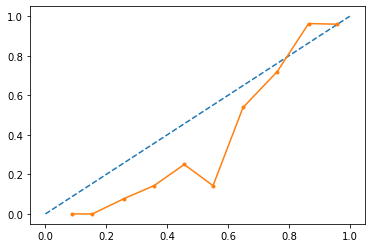

In [13]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

### Decision Tree

In [14]:
# 1) Import model
from sklearn.tree import DecisionTreeClassifier as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# 3) Define model
model = model_constructor(random_state = 0)

# 4) Train model
model.fit(X_train, np.array(y_train))

# 5) Predict
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test) 

# Compute metric
AUC_test = metric(y_test, pred_test_p[:,1])
AUC_test

0.7766745738671099

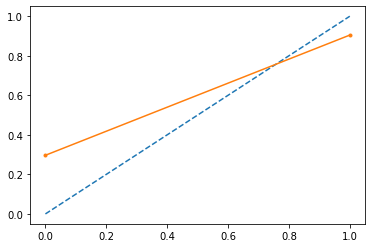

In [13]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Decision tree give a better calibrated probability. Why?

## Calibrate Probabilities

Let's try to calibrate our XGBoost predictions. For that we will use the CalibratedClassifierCV method.

In [15]:
from sklearn.calibration import CalibratedClassifierCV
?CalibratedClassifierCV

Original model.

In [23]:
# 1) Import model
from sklearn.svm import SVC as model_constructor

# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

# 3) Define model
model = model_constructor(probability = True,
                          random_state = 0)

# 4) Train model
model.fit(X_train, np.array(y_train))

# 5) Predict
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test) 

# Compute metric
AUC_test = metric(y_test, pred_test_p[:,1])

Calibrated model.

In [ ]:
?CalibratedClassifierCV

In [24]:
# 3) Define model 
calibrated_model = CalibratedClassifierCV(model_constructor(probability = True,
                                                            random_state = 0),
                                          method = 'isotonic', 
                                          cv=5)

# 4) Train model
calibrated_model.fit(X_train, np.array(y_train))

# 5) Predict
pred_train_p_calibrated = calibrated_model.predict_proba(X_train)
pred_test_p_calibrated = calibrated_model.predict_proba(X_test) 

# Compute metric
AUC_test_calibrated = metric(y_test, pred_test_p_calibrated[:,1])

Auc shouldn't significantly change.

In [25]:
print('Original model  AUC = %.2f - Calibrated model AUC = %.2f' % (AUC_test, AUC_test_calibrated))

Original model  AUC = 0.94 - Calibrated model AUC = 0.93


Let's compare calibration curves

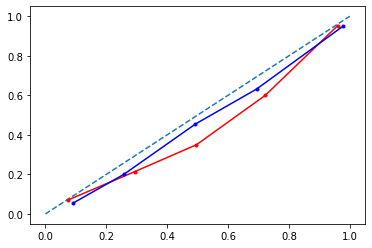

In [26]:
# reliability diagram
fop, mpv = calibration_curve(y_test, pred_test_p[:, 1], n_bins=5)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, pred_test_p_calibrated[:, 1], n_bins=5)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot model reliability
plt.plot(mpv, fop, c = "red", marker='.')
plt.plot(mpv_calibrated, fop_calibrated, c = "blue", marker='.')
plt.show()